# Boundary conditions (and subdomains) in Devito

In the penultimate notebook of this morning tutorial will cover how users can introduce sophisticated boundary conditions into their models. A powerful abstraction available in Devito for implementing boundary conditions is the `SubDomain` object. Before implementing a PML boundary condition for the 2nd order wave-equation below, we will familiarize ourselves with the concept of Devito `SubDomain`'s. 

## Introduction to `SubDomain`'s

Consider the construction of the following `Grid`:

In [1]:
from devito import Grid
shape = (10, 10, 10)
grid = Grid(shape=shape, extent=shape)

This tutorial aims to demonstrate how users can implement various boundary conditions in Devito, building on concepts introduced in previous tutorials. Over the course of this notebook we will go over the implementation of both free surface boundary conditions and perfectly-matched layers (PMLs) in the context of the first-order acoustic wave equation. This tutorial is based on the PML implementation outlined in Liu et al's proceeding (https://doi.org/10.1190/1.3627807).

We will set up our domain with PMLs along the left, right, and bottom edges, and free surface boundaries at the top as shown below.

<img src="figures/boundary_conditions.png" style="width: 220px;"/>

Note that whilst in practice we would want the PML tapers to overlap in the corners, this requires additional subdomains. As such, they are omitted for simplicity.

As always, we will begin by specifying some parameters for our `Grid`:

In [1]:
shape = (101, 101)
extent = (2000., 2000.)
nbpml = 10  # Number of PMLs on each side

We will need to use subdomains to accomodate the modified equations in the PML regions. As `Grid` objects cannot have subdomains added retroactively, we must define our subdomains beforehand.

In [2]:
from devito import SubDomain

class MainDomain(SubDomain):  # Main section with no damping
    name = 'main'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS
            

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.PMLS, self.PMLS), y: ('middle', 0, self.PMLS)}


class Left(SubDomain):  # Left PML region
    name = 'left'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', self.PMLS), y: y}


class Right(SubDomain):  # Right PML region
    name = 'right'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('right', self.PMLS), y: y}
    
    
class Base(SubDomain):  # Base PML region
    name = 'base'
    def __init__(self, PMLS):
        super().__init__()
        self.PMLS = PMLS

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', self.PMLS, self.PMLS), y: ('right', self.PMLS)}


main_domain = MainDomain(nbpml)
left = Left(nbpml)
right = Right(nbpml)
base = Base(nbpml)

And create the grid, attaching our subdomains:

In [3]:
from devito import Grid

grid = Grid(shape=shape, extent=extent,
            subdomains=(main_domain, left, right, base))
x, y = grid.dimensions

We can then begin to specify our problem starting with some parameters.

In [4]:
velocity = 4.  # km/s

We also need a `TimeFunction` object for our wavefield.

In [5]:
from devito import TimeFunction, VectorTimeFunction, NODE

p = TimeFunction(name='p', grid=grid, time_order=2,
                 space_order=6, staggered=NODE)

We will also need to set up a vector auxilliary field in our boundary regions. We will choose a `VectorTimeFunction` object to encapsulate it.

In [6]:
A = VectorTimeFunction(name='A', grid=grid, time_order=2,
                       space_order=6)

A `VectorTimeFunction` is near identical in function to a standard `TimeFunction`, albeit with a field for each grid dimension.

You may have also noticed the keyword `staggered` in the arguments when we created these functions. As one might expect, these are used for specifying where derivatives should be evaluated relative to the grid, as required for implementing formulations such as the first-order acoustic wave equation or P-SV elastic. Passing a function `staggered=NODE` specifies that its derivatives should be evaluated at the node. One can also pass `staggered=x` or `staggered=y` to stagger the grid by half a spacing in those respective directions. Additionally, a tuple of dimensions can be passed to stagger in multiple directions (e.g. `staggered=(x, y)`). `VectorTimeFunction` objects have their associated grids staggered by default.

Next we prepare the source term:

In [7]:
import numpy as np
from examples.seismic import TimeAxis, RickerSource

t0 = 0.  # Simulation starts at t=0
tn = 400.  # Simulation length in ms
dt = 1e2*(1. / np.sqrt(2.)) / 60.  # Time step

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.02
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# Position source centrally in all dimensions
src.coordinates.data[0, :] = 1000.

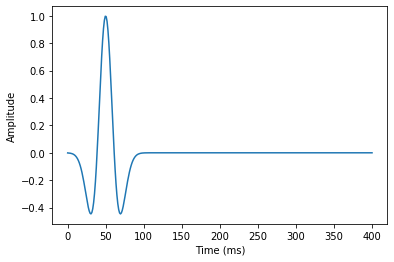

In [8]:
src.show()

For our PMLs, we will need some damping parameter. In this case, we will use a quadratic taper over the absorbing regions on the sides of the domain.

In [9]:
# Damping parameterisation
d_l = (1-0.1*x)**2  # Left side
d_r = (1-0.1*(grid.shape[0]-1-x))**2  # Right side
d_b = (1-0.1*(grid.shape[1]-1-y))**2  # Base edge

Now for our main domain equation:

In [10]:
from devito import Eq, grad, div

eq_p = Eq(p.forward, 2*p - p.backward + dt**2*velocity**2*p.laplace,
           subdomain=grid.subdomains['main'])

# Update our auxilliary field in the main body of the domain
eq_A = Eq(A.forward, A + grad(p),
          subdomain=grid.subdomains['main'])

And add the equations for our damped region:

In [11]:
# Left side
eq_p_l = Eq(p.forward, p - d_l*dt*p + dt*velocity**2*div(A.forward),
            subdomain=grid.subdomains['left'])

eq_A_l = Eq(A.forward, A - d_l*dt*A + grad(p),
            subdomain=grid.subdomains['left'])

# Right side
eq_p_r = Eq(p.forward, p - d_r*dt*p + dt*velocity**2*div(A.forward),
            subdomain=grid.subdomains['right'])

eq_A_r = Eq(A.forward, A - d_r*dt*A + grad(p),
            subdomain=grid.subdomains['right'])


# Base edge
eq_p_b = Eq(p.forward, p - d_b*dt*p + dt*velocity**2*div(A.forward),
            subdomain=grid.subdomains['base'])

eq_A_b = Eq(A.forward, A - d_b*dt*A + grad(p),
            subdomain=grid.subdomains['base'])


Add our free surface boundary conditions:

In [12]:
time = grid.stepping_dim

bc_p = [Eq(p[time+1, x, 3], 0.)]  # Set pressure field to zero at boundary

And our source terms:

In [13]:
src_term = src.inject(field=p.forward, expr=src*dt**2/grid.spacing[0]**2)

Construct our operator and run:

In [14]:
from devito import Operator

op = Operator([eq_A, eq_A_l, eq_A_r, eq_A_b,
               eq_p, eq_p_l, eq_p_r, eq_p_b]
              + src_term + bc_p)

op(time=time_range.num-1)

Operator `Kernel` run in 0.02 s


It is important to remember that the ordering of equations when an `Operator` is created dictates the order of loops within the generated c code. Incorrect ordering can lead to updates occuring in the wrong order.

Now let's plot the wavefield.

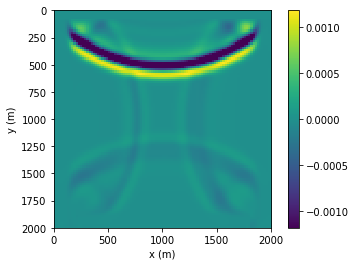

In [15]:
import matplotlib.pyplot as plt

p.data[:, :, :3] = 0 #  Mute out mirrored wavefield above free surface

scale = np.max(p.data[1])
fig = plt.figure()
plt.imshow(p.data[1].T,
           origin="upper",
           vmin=-scale, vmax=scale,
           extent=[0, grid.extent[0], grid.extent[1], 0])
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

As we can see, the wave is effectively damped at the edge of the domain by the 10 layers of PMLs, with diminished reflections back into the domain. The slight visible asymmetry arises due to the stagger of the auxilliary field, which is required for stability.